In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
import seaborn as sns
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss

import torch.optim as optim
from sklearn.metrics import accuracy_score,recall_score,f1_score

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)


## The Network

Function for weight initialization

In [9]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.LSTM):
        nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)


Loading model structures from the "model_structures.py" script

In [10]:
from model_structures import *
net = best_RNN()
print("Number of parameters in model:", get_n_params(net))
print(net)

# Testing flow-through of information within the netwowkr
peptide_random = np.random.normal(0,1, (10, 9, 12)).astype('float32')
peptide_random = Variable(torch.from_numpy(peptide_random))
HLA_random = np.random.normal(0,1, (10, 34, 12)).astype('float32')
HLA_random = Variable(torch.from_numpy(HLA_random))
binding_random = np.random.normal(0,1, (10, 1)).astype('float32')
binding_random = Variable(torch.from_numpy(binding_random))
output = net(peptide_random,HLA_random)
print(output)

Number of parameters in model: 375361
best_RNN(
  (peptide_encoding): LSTM(12, 10, batch_first=True, bidirectional=True)
  (hla_encoding): LSTM(12, 10, batch_first=True, bidirectional=True)
  (drop_out): Dropout(p=0.4, inplace=False)
  (L_in): Linear(in_features=860, out_features=430, bias=True)
  (batchnorm1): BatchNorm1d(430, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (L_2): Linear(in_features=430, out_features=1, bias=True)
)
tensor([[0.5778],
        [0.5094],
        [0.6287],
        [0.6141],
        [0.5521],
        [0.6250],
        [0.5142],
        [0.6862],
        [0.5793],
        [0.5204]], grad_fn=<SigmoidBackward0>)


## Functions for loading and encoding data

In [11]:
def encode_peptide_onehot(aa_seq):
    """Enocding an aa-seqquence using the One-hot scheme

    Args:
        aa_seq (str): Peptide sequence to encode

    Returns:
        np.array: Encoded peptide
    """
    amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F','P', 'S', 'T', 'W', 'Y', 'V']
    one_hot_matrix = pd.DataFrame(np.identity(len(amino_acids)).astype("float32"))
    one_hot_matrix.index = amino_acids
    encoded_aa_seq = []

    for aa in aa_seq:
        if aa == "X" or aa == "-":
            encoded_aa_seq.append(np.array([0 for _ in range(len(amino_acids))]))
        try:    
            encoded_aa_seq.append(one_hot_matrix.loc[aa].to_numpy())
        except KeyError:
            print("Encoding error")
            sys.exit(1)
    

    encoded_aa_seq = np.array(encoded_aa_seq)
    return encoded_aa_seq


def load_blossum62_matrix():
    """Loads the blossum62 substitution matrix using the BioPython library

    Returns:
        pd.DataFrame: A pandas dataframe which holds the blossum62 sub-matrix
    """
    from Bio.Align import substitution_matrices
    blosum62 = substitution_matrices.load("BLOSUM62")
    blossum_aas = list("ARNDCQEGHILKMFPSTWYVBZX*")
    blosum62 = pd.DataFrame(blosum62,columns=blossum_aas,index=blossum_aas)
    return blosum62


def encode_peptide_blossum65(aa_seq,blussom_matrix):
    """Enocding an aa-seqquence using the Blossum62 encoding scheme

    Args:
        aa_seq (str): The aa-sequence we want to encode
        blussom_matrix (pd.DataFrame): A pandas dataframe which holds the blossum62 sub-matrix

    Returns:
        np.array: The encoded peptide sequence
    """

    aa_seq = list(aa_seq.upper())
    encoded_aa_seq = []
    AAs = blussom_matrix.shape[1]
    for aa in aa_seq:
        if aa == "-":
            encoded_aa_seq.append(np.array([0 for _ in range(AAs)]))
        else:
            try:
                encoded_aa_seq.append(blussom_matrix.loc[aa].to_numpy())
            except KeyError:
                print("Encoding error")
                sys.exit(1)
    
    encoded_aa_seq = np.array(encoded_aa_seq)
    return encoded_aa_seq


def encode_peptide_aaindex(aa_seq,aaindex_PCA):
    """Enocding an aa-seqquence using the AAindex encoding scheme.

    Args:
        aa_seq (str): The aa-sequence we want to encode
        aaindex_PCA (pd.DataFrame):  A pandas dataframe which holds the AAindex encoding scheme

    Returns:
        np.array: The encoded peptide sequence
    """

    aa_seq = list(aa_seq.upper())
    encoded_aa_seq = []
    PCs = aaindex_PCA.shape[1]
    for aa in aa_seq:
        if aa == "X" or aa == "-":
            encoded_aa_seq.append(np.array([0 for x in range(PCs)]))
        else:
            try:
                encoded_aa_seq.append(aaindex_PCA.loc[aa].to_numpy())
            except KeyError:
                print("Encoding error")
                sys.exit(1)
    return np.array(encoded_aa_seq)

def encode_multiple(aa_seq,aaindex_PCA,blussom_matrix):
    """Enocding an aa-seqquence using the the Combined encoding schemes of AAindex, Blossum62 and One-hot.

    Args:
        aa_seq (str): The aa-sequence we want to encode
        aaindex_PCA (pd.DataFrame):  A pandas dataframe which holds the AAindex encoding scheme
        blussom_matrix (pd.DataFrame):  A pandas dataframe which holds the blossum62 sub-matrix

    Returns:
        np.array: The encoded peptide sequence
    """
    amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F','P', 'S', 'T', 'W', 'Y', 'V']
    one_hot_matrix = pd.DataFrame(np.identity(len(amino_acids)).astype("float32"))
    one_hot_matrix.index = amino_acids
    encoded_aa_seq = []


    aa_seq = list(aa_seq.upper())
    encoded_aa_seq = []
    PCs = aaindex_PCA.shape[1]
    for aa in aa_seq:
        if aa == "X" or aa == "-":
            encoded_aa_seq.append(np.array([0 for x in range(56)]))
        else:
            try:
                aa_index_encoding = aaindex_PCA.loc[aa].to_numpy()
                blossum_encoding = blussom_matrix.loc[aa].to_numpy()
                
                onehot_encoding = one_hot_matrix.loc[aa].to_numpy()
                encoding = np.concatenate((aa_index_encoding,blossum_encoding,onehot_encoding))
                encoded_aa_seq.append(encoding)

            except KeyError:
                print("Encoding error")
                sys.exit(1)
    return np.array(encoded_aa_seq)

def encode_dataset(df,aa_index_matrix,blosum62_matrix,HLA_dict,peptide_len,padding="right"):
    """Encodes the filtered, balanced and partioned dataset. This is done in three major steps. 
    1) The MHCI-allele code is converted to the paratope sequence. 
    2) The MHCI is encoded using one of four different schemes.
    3) The peptide sequence is encoded using one of four different schemes.
    4) The peptide sequence is padded to a specified length.
    5) Encoding the binding score retrived from netMHCpan
    6) The output label y is created based on the number of positive subjects from the raw data
        1 ~ If number of positive subjects is greater than 0
        0 ~ If number of positive subjects is equal to 0
    

    Args:
        df (pd.Dataframe): The dataframe containing the dataset which is to be encoded
        aa_index_matrix (pd.DataFrame): A pandas dataframe which holds the AAindex encoding scheme
        blussom_matrix (pd.DataFrame):  A pandas dataframe which holds the blossum62 sub-matrix
        HLA_dict (dict): A dictionary used to translate the MHCI-allele code is converted to the paratope sequence. 
        peptide_len (int): The length we want the encoded sequence to have.
        padding (str, optional): The strategy used to pad the peptide sequences. Defaults to "right".

    Returns:
        np.array: Encoded peptide
        np.array: Encoded HLA
        np.array: Encoded Binding-score
        np.array: Encoded Labels

    """
    encoded_peptides = []
    encoded_labels = []
    encoded_hlas = []
    encoded_binding_scores = []
    for i,row in df.iterrows():
        
        HLA = HLA_dict[row["HLA_allele"].replace(":","")]
        #encoded_HLA = encode_peptide_aaindex(HLA,aa_index_matrix)
        encoded_HLA = encode_peptide_onehot(HLA)
        # encoded_HLA = encode_peptide_blossum65(HLA,blosum62_matrix)
        # encoded_HLA = encode_multiple(HLA,aaindex_PCA,blosum62_matrix)

        peptide = row["peptide"]
        #encoded_peptide = encode_peptide_aaindex(peptide,aa_index_matrix)
        encoded_peptide = encode_peptide_onehot(peptide)
        # encoded_peptide = encode_peptide_blossum65(peptide,blosum62_matrix)
        # encoded_peptide = encode_multiple(peptide,aaindex_PCA,blosum62_matrix)
        

        binding_score = row['binding_score']

        # Adding padding
        if len(encoded_peptide) < peptide_len:
            n_added = peptide_len-len(encoded_peptide)
            if padding == "right":
                encoded_peptide = np.pad(encoded_peptide, ((0, 1), (0, 0)), 'constant')
            elif padding == "left":
                encoded_peptide = np.pad(encoded_peptide, ((1, 0), (0, 0)), 'constant')
            elif padding == "random":
                top_pad = random.choice([0,1])
                bot_pad = 1-top_pad
                encoded_peptide = np.pad(encoded_peptide, ((top_pad, bot_pad), (0, 0)), 'constant')


        encoded_label = min(1,row["positive_subjects"])
        encoded_peptides.append(encoded_peptide)
        encoded_hlas.append(encoded_HLA)
        encoded_labels.append(encoded_label)
        encoded_binding_scores.append(binding_score)
    
    encoded_peptides = np.array(encoded_peptides).astype('float32')
    encoded_hlas = np.array(encoded_hlas).astype('float32')
    encoded_labels = np.array(encoded_labels).astype('float32').reshape(-1,1)
    encoded_binding_scores = np.array(encoded_binding_scores).astype('float32').reshape(-1,1)

    return encoded_peptides, encoded_hlas, encoded_binding_scores, encoded_labels


## Functions for plotting model statistics

In [12]:
def plot_epochs(K, lst_train_acc, lst_val_acc): 
    """For each fold, plot the accuracy on
    train and validation data for each epoch

    Args:
        K (int): Number of CV folds
        lst_train_acc (list of lists): list of lists containing training accuracy for each fold pr epoch
        lst_val_acc (list of lists): list of lists containing validation accuracy for each fold pr epoch
    """
    plt.figure()
    for i in range(K):
        epoch = np.arange(len(lst_train_acc[i]))
        plt.plot(epoch, lst_train_acc[i], 'r', epoch, lst_val_acc[i], 'b')
    plt.title("Performance of {} fold CV".format(K))
    plt.legend(['Train Accuracy','Validation Accuracy'])
    plt.xlabel('epochs'), plt.ylabel('Acc')
    plt.show()


def calculate_avg_val_performance(K, N, lst_val_acc, lst_val_lab, lst_val_pred):
    """Calculate the generalization error

    Args:
        lst_val_acc (list of lists): list of lists containing validation accuracies for each fold
        lst_val_lab (list of lists): list of lists containing validation labels for each fold
        lst_val_pred (list of lists): list of lists containing validation predictions for each fold
        N (int): Total number of observations in data set
    """
    avg_recall = 0
    avg_accuracy = 0 
    avg_f1 = 0

    res = np.zeros((K,5))
    for i in range(K):
        best_epoch_model = np.argmax(lst_val_acc[i])
        n = len(lst_val_lab[i][best_epoch_model])
        accuracy = accuracy_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])
        recall = recall_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])
        f1 = f1_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])

        res[i][0] = best_epoch_model
        res[i][1] = n
        res[i][2] = accuracy
        res[i][3] = recall
        res[i][4] = f1

        avg_recall += (n/N) * recall
        avg_accuracy += (n/N) * accuracy
        avg_f1 += (n/N) * f1

    print(f"Best average results - Recall: {avg_recall} accuracy: {avg_accuracy} f1-score: {avg_f1}")
    return res

def plot_roc_curve_best_epoch(valid_losses, predictions, targets):
    """Plots the ROC curve for the best epoch

    Args:
        valid_losses (list): list of validation loss
        predictions (list of lists): model predictions for all epochs per CV fold
        targets (list of lists): target values for all epochs per CV fold
    """
    best_epoch_model = np.argmin(valid_losses)
    print("Best Epoch",best_epoch_model)
    fpr, tpr, threshold = metrics.roc_curve(targets[best_epoch_model],predictions[best_epoch_model])
    roc_auc = metrics.auc(fpr,tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def plot_PR_curve_best_epoch(valid_losses, predictions, targets):
    """Plots the PR curve for the best epoch

    Args:
        valid_losses (list): list of validation loss
        predictions (list of lists): model predictions for all epochs per CV fold
        targets (list of lists): target values for all epochs per CV fold
    """
    from sklearn import metrics
    best_epoch_model = np.argmin(valid_losses)
    precision, recall, thresholds = metrics.precision_recall_curve(targets[best_epoch_model], predictions[best_epoch_model])
    roc_auc = metrics.auc(recall, precision)
    plt.title('Precission-Recall curve')
    plt.plot(recall, precision, 'b', label = 'AUCpr = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Recall')
    plt.xlabel('Precession')
    plt.show()


def pick_optimal_threshold_auc(fpr, tpr, threshold):
    """Picks the optimal threshold for determining 
    immunogenic/non-immunogenic targets on unlabelled data

    Args:
        fpr (float): false positive rate  
        tpr (float): true positive rate
        threshold (float): The current threshold to update

    Returns:
        int: position of highest geometric mean
    """
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    return ix

def plot_all_roc_curves(K,valid_losses, predictions, targets):
    """Plot of ROC curve for all K CV folds

    Args:
        K (int): number of CV folds
        valid_losses (list): list of validation loss
        predictions (list of lists): model predictions for all epochs per CV fold
        targets (list of lists): target values for all epochs per CV fold
    """
    fig = plt.figure()
    plt.title('Receiver Operating Characteristic')
    for k in range(K):
        best_epoch_model = np.argmin(valid_losses[k])
        

        fpr, tpr, threshold = metrics.roc_curve(targets[k][best_epoch_model],predictions[k][best_epoch_model])
        roc_auc = round(metrics.auc(fpr,tpr),3)
        best_threshold = pick_optimal_threshold_auc(fpr, tpr, threshold)
        print(f"Best Epoch in K {k}",best_epoch_model,"best threshold:",threshold[best_threshold])
        plt.plot(fpr, tpr,label = f'CV {k+1} AUC {roc_auc}')
        plt.plot(fpr[best_threshold], tpr[best_threshold],color="black",marker="d")
        plt.plot()

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    
def plot_all_PR_curves(K,valid_losses, predictions, targets):
    """Plot of PR curve for all K CV folds

    Args:
        K (int): number of CV folds
        valid_losses (list): list of validation loss
        predictions (list of lists): model predictions for all epochs per CV fold
        targets (list of lists): target values for all epochs per CV fold
    """
    fig = plt.figure()
    plt.title('Receiver Operating Characteristic')
    for k in range(K):
        best_epoch_model = np.argmin(valid_losses[k])
        precision, recall, thresholds = metrics.precision_recall_curve(targets[k][best_epoch_model], predictions[k][best_epoch_model])
        roc_auc = round(metrics.auc(recall, precision),3)
        plt.plot(recall, precision,label = f'CV {k+1} AUC {roc_auc}')
    plt.legend(loc = 'lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Recall')
    plt.xlabel('Precision')
    plt.show()




## Functions for training the models

In [13]:

def plot_learning_curve(train_accuracies,val_accuracies):
    """Plot accuracy during training

    Args:
        train_accuracies (list): list of training accuracies on target values in current CV fold
        val_accuracies (list): list of validation accuracies on target values in current CV fold
    """
    epoch = np.arange(len(train_accuracies))
    plt.figure()
    plt.plot(epoch, train_accuracies, 'r', epoch, val_accuracies, 'b')
    plt.legend(['Train Accucary','Validation Accuracy'])
    plt.xlabel('epochs'), plt.ylabel('Acc')


def validation(model,device,valid_loaders,train_loaders):
    """Generates model predictions on train and validation data

    Args:
        model (pytorch model): trained neural network 
        device (state): either cuda enabled or not
        valid_loaders (Data loader): Data loader for validation data
        train_loaders (Data loader): Data loader for training data

    Returns:
        lists: lists of predictions, targets and validation loss
    """
    peptide_val_loader,HLA_val_loader,label_val_loader,binding_score_val_loader = valid_loaders
    peptide_train_loader,HLA_train_loader,label_train_loader,binding_score_train_loader = train_loaders
    model.eval()
    with torch.no_grad():
        all_train_predictions = []
        all_train_targets = []
        for i in range(len((peptide_train_loader))):
            train_peptides = peptide_train_loader[i].to(device)
            train_HLA = HLA_train_loader[i].to(device)
            train_labels = label_train_loader[i].to(device)
            train_binding_scores = binding_score_train_loader[i].to(device)
            outputs = model(train_peptides,train_HLA)
            all_train_predictions += outputs.cpu().numpy().tolist()
            all_train_targets += train_labels.cpu().numpy().tolist()
        
        all_val_targets = []
        all_val_predictions = []
        for j in range(len((peptide_val_loader))):
            val_peptides = peptide_val_loader[j].to(device)
            val_HLA = HLA_val_loader[j].to(device)
            val_labels = label_val_loader[j].to(device)
            val_binding_scores = binding_score_val_loader[j].to(device)
            outputs = model(val_peptides,val_HLA)
            all_val_predictions += outputs.cpu().numpy().tolist()
            all_val_targets += val_labels.cpu().numpy().tolist()

        validation_loss = mean_squared_error(all_val_targets,all_val_predictions)
        # loss_function = nn.BCELoss()
        # targets = torch.tensor(all_val_targets)
        # predictions = torch.tensor(all_val_predictions)
        # validation_loss = loss_function(targets,predictions)/len(targets)
        

    return all_train_targets,all_train_predictions,all_val_targets,all_val_predictions,validation_loss


def testing(model,device,test_loader):
    """Testing model every epoch on testing data

    Args:
        model (pytorch model): Trained neural network
        device (state): enable cuda or not
        test_loader (Data loader): Data loader for test data 

    Returns:
        lists: Target and prediction values 
    """
    peptide_test_loader,HLA_test_loader,label_test_loader,binding_score_test_loader = test_loader
    model.eval()
    all_test_predictions = []
    all_test_targets = []
    with torch.no_grad():
        test_peptides = peptide_test_loader[0].to(device)
        test_HLA = HLA_test_loader[0].to(device)
        test_labels = label_test_loader[0].to(device)
        test_binding_scores = binding_score_test_loader[0].to(device)
        outputs = model(test_peptides,test_HLA)
        all_test_predictions.append(outputs.cpu().numpy().tolist())
        all_test_targets.append(test_labels.cpu().numpy().tolist())
    return all_test_targets,all_test_predictions
    



def train(model, device, epochs, train_loaders, valid_loaders, test_loaders, learning_rate, weight_decay):
    """train the model 

    Args:
        model (pytorch model): untrained neural network
        device (state): cuda enabled or not
        epochs (int): number of epoch to do
        train_loaders (Data loaders): Data loaders for training data
        valid_loaders (Data loaders): Data loaders for validation data
        test_loaders (Data loaders): Data loaders for test data
        learning_rate (float) : learning rate value
        weight_decay (float) : weight decay value

    Returns:
        pytorch model: trained neural network
        lists: train and validation losses
    """
    
    peptide_train_loader,HLA_train_loader,label_train_loader,binding_score_train_loader = train_loaders
    model.to(device)
    criterion = nn.MSELoss()
    # criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early stopping
    the_last_loss = 100
    patience = 4
    trigger_times = 0
    
    all_val_targets_pr_epoch = []
    all_val_predictions_pr_epoch = []

    all_test_targets_pr_epoch = []
    all_test_predictions_pr_epoch = []

    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        current_loss = 0
        
        for train_batch_index in range(len((peptide_train_loader))):
            train_peptides = peptide_train_loader[train_batch_index].to(device)
            train_HLA = HLA_train_loader[train_batch_index].to(device)
            train_labels = label_train_loader[train_batch_index].to(device)
            train_binding_scores = binding_score_train_loader[train_batch_index].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            outputs = model(train_peptides,train_HLA)
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()
            current_loss += loss.item()
        train_losses.append(current_loss/len((peptide_train_loader)))

        all_train_targets,all_train_predictions,all_val_targets,all_val_predictions,validation_loss = validation(model,device,valid_loaders,train_loaders)
        

        val_losses.append(validation_loss)
        all_val_targets_pr_epoch.append(all_val_targets)
        all_val_predictions_pr_epoch.append(all_val_predictions)

        all_test_targets,all_test_predictions = testing(model,device,test_loaders)
        all_test_targets_pr_epoch.append(all_test_targets)
        all_test_predictions_pr_epoch.append(all_test_predictions)

        if epoch % 5 == 0:
            print("Epoch %2i : Train Loss %f , Validation loss %f" % (epoch+1, train_losses[-1], val_losses[-1]))
        

        # Early stopping
        the_current_val_loss = val_losses[-1]
        the_last_val_loss = 0 if len(val_losses) < 2 else val_losses[-2]


        if the_current_val_loss > the_last_val_loss:
            trigger_times += 1

            if trigger_times >= patience:
                print('Early stopping at epoch',epoch," with patience",patience)
                return model,train_losses,val_losses,all_val_targets_pr_epoch,all_val_predictions_pr_epoch,all_test_targets_pr_epoch, all_test_predictions_pr_epoch

        else:
            trigger_times = 0

    return model,train_losses,val_losses,all_val_targets_pr_epoch,all_val_predictions_pr_epoch,all_test_targets_pr_epoch, all_test_predictions_pr_epoch

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)


Device state: cpu


## Encoding entire data set

In [14]:
# Loading the encoding schemes
aaindex_PCA = pd.read_csv('../data/PCA_repr_aa.csv',index_col=0)
blosum62 = load_blossum62_matrix()
blosum62 = (blosum62 - blosum62.mean()) / blosum62.std()

# HLA
hla_database = pd.read_csv('../data/formatted_hla2paratope_MHC_pseudo.dat', sep=' ',index_col=0)
# hla_database = pd.read_csv('../data/MHC_full.dat', sep=' ',index_col=0)
hla_dic = hla_database.to_dict("dict")["pseudo"]

# Reading the data 
all_data = pd.read_csv("../data/ifng_true_balanced_w_parts_w_binding_scores_w_iedb.csv")
all_data = all_data.sample(frac=1, random_state=1).reset_index(drop=True)
all_data["peptide_len"] = all_data["peptide"].apply(len)
all_data = all_data[(all_data["HLA_allele"] == "HLA-A*02:01") & (all_data["peptide_len"] == 9)]
print("## Encoding dataset")

all_peptides_encoded,all_HLA_encoded,all_binding_scores_encoded,all_label_encoded = encode_dataset(all_data,aaindex_PCA,blosum62,hla_dic,peptide_len=9,padding="right")


print("Shape of peptides",all_peptides_encoded.shape)
print("Shape of hla",all_HLA_encoded.shape)
print("Shape of binding_scores",all_binding_scores_encoded.shape)


## Encoding dataset


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Encoding error
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 4554, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 4562, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'X'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-11-e597e34ba508>", line 19, in encode_peptide_onehot
    encoded_aa_seq.append(one_hot_matrix.loc[aa].to_numpy())
  File "/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py", line 895, in __getitem__
    return self._getitem_axis(maybe_callable, a

TypeError: object of type 'NoneType' has no len()

## 5-fold cross-validation loop

In [11]:
N = len(all_data)
no_epoch = 100
lst_train_accuracies = []

lst_val_losses = []
lst_val_predictions = []
lst_val_labels = []

lst_test_targets = []
lst_test_predictions = []

lst_roc_auc = []
lst_pr_auc = []

best_roc_auc_indx = 0
best_roc_auc = 0

# Chose parameters 
# Best current parameters RNN
batch_size = 40
learning_rate = 0.0001
weight_decay = 0.001
dropout = 0.4
RNN_encodings = 10


## The partitions to use for training, validation ##
test_parts = [0]
validation_parts = [2]
training_parts = [1,3,4,5,6,7,8,9]
print("the val and train parts")
print(validation_parts, training_parts)

train_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(training_parts)]
train_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(training_parts)]
train_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(training_parts)]
train_label_encoded = all_label_encoded[all_data["parts"].isin(training_parts)]

val_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(validation_parts)]
val_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(validation_parts)]
val_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(validation_parts)]
val_label_encoded = all_label_encoded[all_data["parts"].isin(validation_parts)]

test_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(test_parts)]
test_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(test_parts)]
test_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(test_parts)]
test_label_encoded = all_label_encoded[all_data["parts"].isin(test_parts)]

## Batches for training the model ##
peptide_train_loader = list(DataLoader(train_peptides_encoded,batch_size=batch_size))
HLA_train_loader = list(DataLoader(train_HLA_encoded,batch_size=batch_size))
binding_score_train_loader = list(DataLoader(train_binding_scores_encoded,batch_size=batch_size))
label_train_loader = list(DataLoader(train_label_encoded,batch_size=batch_size))

peptide_val_loader = list(DataLoader(val_peptides_encoded,batch_size=batch_size))
HLA_val_loader = list(DataLoader(val_HLA_encoded,batch_size=batch_size))
binding_score_val_loader = list(DataLoader(val_binding_scores_encoded,batch_size=batch_size))
label_val_loader = list(DataLoader(val_label_encoded,batch_size=batch_size))

peptide_test_loader = list(DataLoader(test_peptides_encoded,batch_size=len(test_label_encoded)))
HLA_test_loader = list(DataLoader(test_HLA_encoded,batch_size=len(test_label_encoded)))
binding_score_test_loader = list(DataLoader(test_binding_scores_encoded,batch_size=len(test_label_encoded)))
label_test_loader = list(DataLoader(test_label_encoded,batch_size=len(test_label_encoded)))

train_loaders = (peptide_train_loader, HLA_train_loader, label_train_loader, binding_score_train_loader)
val_loaders = (peptide_val_loader, HLA_val_loader, label_val_loader, binding_score_val_loader)
test_loaders = (peptide_test_loader, HLA_test_loader, label_test_loader, binding_score_test_loader)
torch.manual_seed(0)
net = best_RNN()
net.apply(initialize_weights)

trained_model,train_losses,val_losses,all_val_targets_pr_epoch,all_val_predictions_pr_epoch,all_test_targets_pr_epoch, all_test_predictions_pr_epoch = train(net,device,no_epoch,train_loaders,val_loaders,test_loaders, learning_rate, weight_decay)

        


the val and train parts
[2] [1, 3, 4, 5, 6, 7, 8, 9]
Epoch  1 : Train Loss 0.300934 , Validation loss 0.250306
Epoch  6 : Train Loss 0.207523 , Validation loss 0.213970
Epoch 11 : Train Loss 0.178974 , Validation loss 0.203536
Epoch 16 : Train Loss 0.155040 , Validation loss 0.202423
Epoch 21 : Train Loss 0.141293 , Validation loss 0.200977
Epoch 26 : Train Loss 0.128324 , Validation loss 0.200931
Early stopping at epoch 27  with patience 4


In [14]:
def calculate_roc_auc(targets, predictions):
    """calculate the roc auc

    Args:
        targets (list): list of target values for given epoch
        predictions (list): list of model predictions for given epoch

    Returns:
        float: the roc auc value
    """
    fpr, tpr, threshold = metrics.roc_curve(targets,predictions)
    roc_auc = round(metrics.auc(fpr,tpr),3)
    return roc_auc

def calculate_pr_auc(targets, predictions):
    """calculate the pr auc

    Args:
        targets (list): list of target values for given epoch
        predictions (list): list of model predictions for given epoch

    Returns:
        float: the pr auc value
    """
    precision, recall, thresholds = metrics.precision_recall_curve(targets,predictions)
    pr_auc = round(metrics.auc(recall, precision),3)
    return pr_auc

def get_testing_performance(all_val_targets_pr_epoch,all_val_predictions_pr_epoch,all_test_targets_pr_epoch,all_test_predictions_pr_epoch):
    """get the roc auc and pr auc on testing data 

    Args:
        all_val_targets_pr_epoch (list): list of targets pr epoch
        all_val_predictions_pr_epoch (list): list of model predictions pr epoch
        all_test_targets_pr_epoch (list): list of targets pr epoch
        all_test_predictions_pr_epoch (list): list of model predictions pr epoch

    Returns:
        roc_test: roc auc value on test data
        auPR_test: pr auc value on test data 
    """
    # Finding the best epoch
    roc_scores = []
    for targets,predictions in zip(all_val_targets_pr_epoch,all_val_predictions_pr_epoch):
        roc_scores.append(calculate_roc_auc(targets,predictions))
    
    best_validation_epoch = np.argmax(roc_scores)
    print(best_validation_epoch)
    roc_test = calculate_roc_auc(all_test_targets_pr_epoch[best_validation_epoch][0],all_test_predictions_pr_epoch[best_validation_epoch][0])
    auPR_test = calculate_pr_auc(all_test_targets_pr_epoch[best_validation_epoch][0],all_test_predictions_pr_epoch[best_validation_epoch][0])
    return roc_test, auPR_test

roc_test, auPR_test = get_testing_performance(all_val_targets_pr_epoch,all_val_predictions_pr_epoch,all_test_targets_pr_epoch,all_test_predictions_pr_epoch)
print(f"The test performance of the best model selected based on the Valdiation data:\nroc-AUC: {roc_test} \nauPR: {auPR_test}")




23
The test performance of the best model selected based on the Valdiation data:
roc-AUC: 0.746 
auPR: 0.817


## Occlusion sensitivity analysis

[0, 6, 2, 1, 8, 5, 4, 7, 3]
[0.06518049775192632, 0.06388513931371072, 0.06322074579217433, 0.051717127145698545, 0.04840769526483812, 0.04781015895301607, 0.04765555165555164, 0.04579190693476406, 0.014477661334804173]
[0.024780367542950973, 0.0244053141568648, 0.02576004052609704, 0.02681621788683254, 0.03037726868935671, 0.028272949683176778, 0.028046328663316793, 0.027578559120738075, 0.023479891896630262]


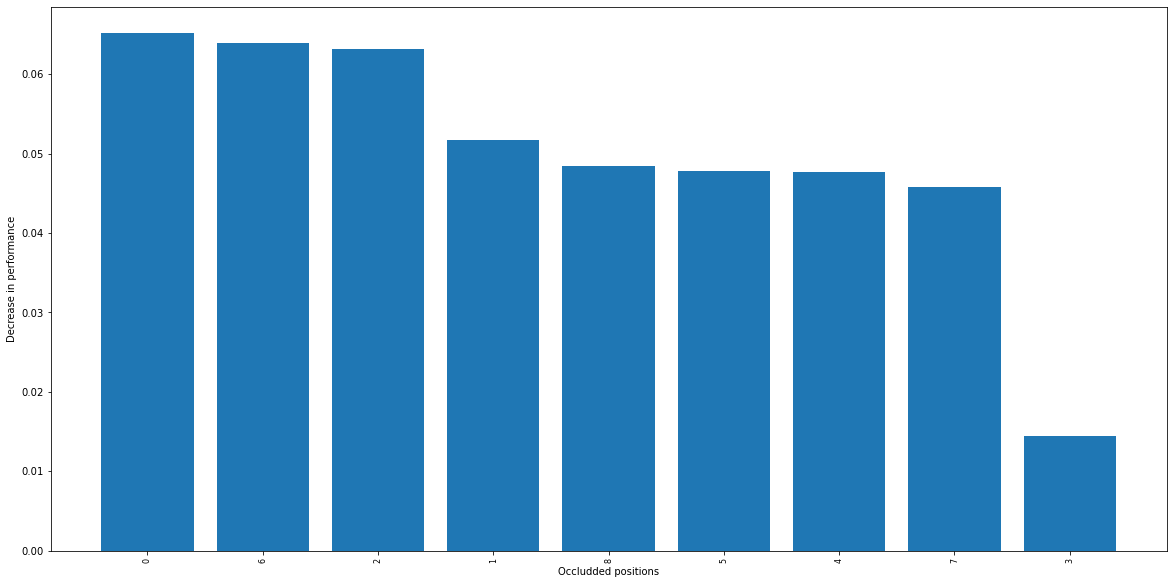

In [18]:
def occlude_peptide_position(input_data,occlusion_positions):
    """Masks row of input data with 0-mask

    Args:
        input_data (tensor): Tensor containg the peptide encoding scheme
        occlusion_positions (tuple): Positions to mask

    Returns:
        tensor: Data with masked position
    """
    input_data = input_data.copy()
    input_data[:,occlusion_positions,:] = 0
    return input_data


def occlusion_sensitivity_analysis(model, valid_loaders,N_positions,baseline_score):
    """Do occlusion sensitivity analysis 

    Args:
        model (pytorch model): trained neural network
        valid_loaders (Data loader): Data loader for validation data
        N_positions (int): position(s) to occlude
        baseline_score (float): AUC of model on non-occluded peptides
    """
    import itertools
    peptide_val_loader,HLA_val_loader,label_val_loader,binding_score_val_loader = valid_loaders
    model.eval()
    positions = range(N_positions)
    occlussions = [list(itertools.combinations(positions,1)),list(itertools.combinations(positions,2)),list(itertools.combinations(positions,3))]
    base_line_auc = baseline_score
    position_occlusion_dict = {pos:[] for pos in range(N_positions)}

    with torch.no_grad():
        for length, occlusion_combinations in enumerate(occlussions):
            for occlusion in occlusion_combinations:
                all_val_targets = []
                all_val_predictions = []
                for j in range(len((peptide_val_loader))):
                    val_peptides = peptide_val_loader[j].to(device)
                    occluded_peptides = torch.clone(val_peptides)
                    occluded_peptides[:,occlusion,:] = 0
                    val_HLA = HLA_val_loader[j].to(device)
                    val_labels = label_val_loader[j].to(device)
                    val_binding_scores = binding_score_val_loader[j].to(device)
                    outputs = model(occluded_peptides,val_HLA)
                    all_val_predictions += outputs.cpu().numpy().tolist()
                    all_val_targets += val_labels.cpu().numpy().tolist()
                fpr, tpr, threshold = metrics.roc_curve(all_val_targets,all_val_predictions)
                roc_auc = metrics.auc(fpr,tpr)
                difference_from_baseline = base_line_auc-roc_auc
                for occluded_position in occlusion:
                    position_occlusion_dict[occluded_position].append(difference_from_baseline)

    
    average_decrease_in_performance = {pos:np.mean(position_occlusion_dict[pos]) for pos in position_occlusion_dict.keys()}
    std_decrease_in_performance = {pos:np.std(position_occlusion_dict[pos]) for pos in position_occlusion_dict.keys()}

    sorted_occlusions = sorted(average_decrease_in_performance.keys(), key= lambda x: average_decrease_in_performance[x],reverse=True)
    sorted_decreases = [average_decrease_in_performance[occ] for occ in sorted_occlusions]
    sorted_std =  [std_decrease_in_performance[occ] for occ in sorted_occlusions]

    print(sorted_occlusions)
    print(sorted_decreases)
    print(sorted_std)
    fig = plt.figure(figsize=(20,10))
    plt.bar(np.arange(len(sorted_decreases)), sorted_decreases)
    # plt.errorbar(np.arange(len(sorted_decreases)), sorted_decreases,yerr=sorted_std, fmt="", color="k", ls="",capsize=10)
    plt.xticks(np.arange(len(sorted_decreases)),sorted_occlusions,rotation=90, size=8)
    plt.xlabel("Occludded positions")
    plt.ylabel("Decrease in performance")
    plt.show()

occlusion_sensitivity_analysis(trained_model, test_loaders, 9, 0.746)